In this notebook we will first analyze the bike share dataset using pandas and then build a linear regression model from scratch to forecast the demand for the last 30 days

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
bikeshare_df = pd.read_csv('bikeshare_hour.csv')

print (bikeshare_df.head())
print (bikeshare_df.describe())
print (bikeshare_df.shape)
print (bikeshare_df.isnull().sum(axis = 0))

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  
          instant        season            yr          mnth            hr  \
count  17379.0000  173

So we can see that there are no null values and total number of rows is 17379. Below is the desc of the dataset

	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
	

In [2]:
def define_seasons(x):
    if x == 1:
        return 'Spring'
    elif x ==2:
        return 'Summer'
    elif x ==3:
        return 'Fall'
    elif x ==4:
        return 'Winter'

bikeshare_df['seasons_defined'] = bikeshare_df['season'].apply(define_seasons)

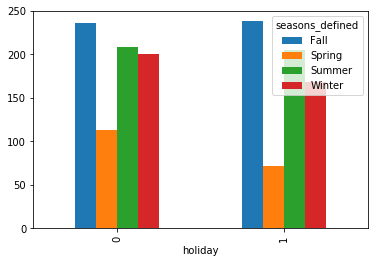

In [3]:
#first let's look at the rentals by weather. So the hourly average is highest in Fall
bikeshare_df.groupby(['holiday','seasons_defined']).mean()['cnt'].unstack().plot.bar()

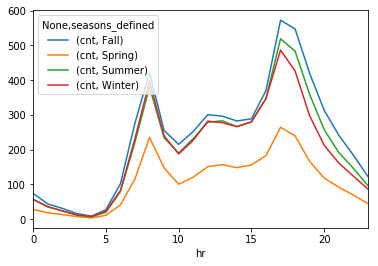

In [4]:
#Now lets look at which time of the day is the busiest by season
bikeshare_df.groupby(['hr','seasons_defined']).mean()[['cnt']].unstack().plot.line()


In [5]:
def weather_sit(x):
    if x == 1:
        return 'Clear'
    elif x ==2:
        return 'Mist'
    elif x ==3:
        return 'Light Snow and rain'
    elif x ==4:
        return 'Heavey rain and snow'

bikeshare_df['weather_sit_define'] = bikeshare_df['weathersit'].apply(weather_sit)

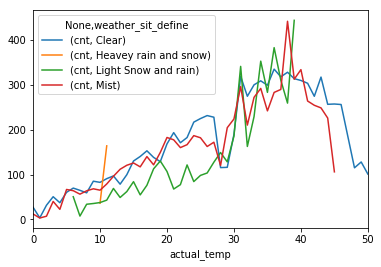

In [6]:
bikeshare_df['actual_temp'] = (bikeshare_df['atemp']*50).round().astype(int)

bikeshare_df.groupby(['actual_temp','weather_sit_define']).mean()[['cnt']].unstack().plot.line()

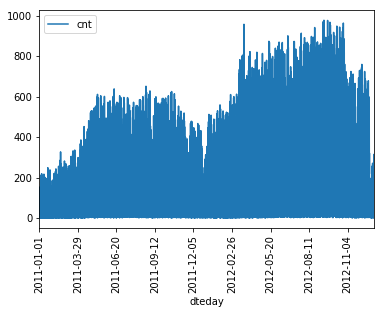

In [7]:
#Let's plot the total number of rentals and see how is looks like

bikeshare_df[['dteday','cnt']].plot(x = 'dteday', y = 'cnt',rot=90)

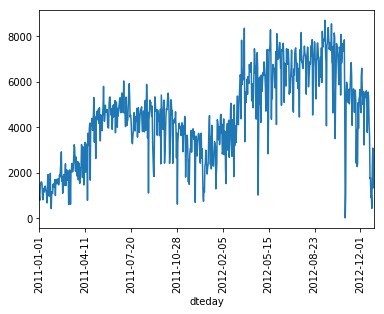

In [8]:
#same graph on a daily basis
bikeshare_df.groupby('dteday').sum()['cnt'].plot(rot=90)

In [9]:
print (bikeshare_df['dteday'].nunique())
print (bikeshare_df['dteday'].min())
print (bikeshare_df['dteday'].max())


731
2011-01-01
2012-12-31


In [10]:
#Now we will be building a model to predict the number of rentals for the month of Dec 2012
#We will be using the daily dataset for this model
bikeshare_daily_df = pd.read_csv('bikeshare_day.csv')
print (bikeshare_daily_df['dteday'].nunique())
print (bikeshare_daily_df['dteday'].min())
print (bikeshare_daily_df['dteday'].max())


731
2011-01-01
2012-12-31


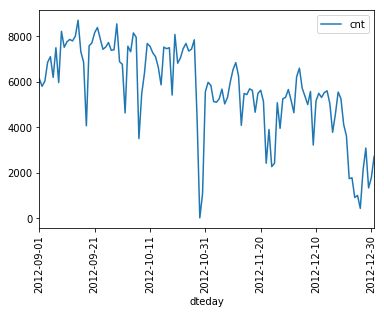

In [11]:
bikeshare_daily_df[bikeshare_daily_df['dteday']>='2012-09-01'][['dteday','cnt']].plot(x = 'dteday', y ='cnt', rot=90)

First let's do some feature engineering. The features we will be using are:
- Day of week (dummy)
- Season (dummy)
- Temperature
- Humidity
- Weather type (dummy)
- Holiday Flag
- Windspeed
- 1,3,7,14,30,60 and 140 days mean, median, min, max, std
- 1,3,7,14,30,60 and 140 days mean, median, min, max, std of difference
- DOW average for the last 4 weeks and 20 weeks
- count on the same day a year ago

The evaluation metric is root mean square errors

In [12]:
#Let's create the dummy variables first
dummies_day_week = pd.get_dummies(bikeshare_daily_df['weekday']).rename(columns=lambda x: 'weekday_' + str(x))

In [13]:
bikeshare_daily_df = pd.concat([bikeshare_daily_df, dummies_day_week], axis=1)

In [14]:
dummies_season = pd.get_dummies(bikeshare_daily_df['season']).rename(columns=lambda x: 'season_' + str(x))

In [15]:
bikeshare_daily_df = pd.concat([bikeshare_daily_df, dummies_season], axis=1)

In [16]:
dummies_weather = pd.get_dummies(bikeshare_daily_df['weathersit']).rename(columns=lambda x: 'weather_' + str(x))

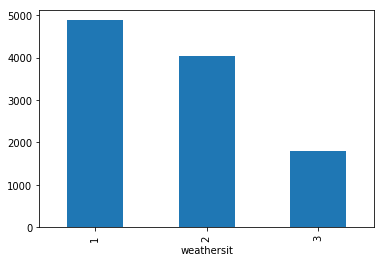

In [17]:
bikeshare_daily_df.groupby('weathersit').mean()['cnt'].plot.bar()

In [18]:
bikeshare_daily_df = pd.concat([bikeshare_daily_df, dummies_weather], axis=1)

In [19]:

bikeshare_daily_df['mnth'] = pd.to_datetime(bikeshare_daily_df['dteday'], errors='coerce').dt.month
bikeshare_daily_df['week_num'] = pd.to_datetime(bikeshare_daily_df['dteday'], errors='coerce').dt.week+1

In [20]:
dummies_mnth = pd.get_dummies(bikeshare_daily_df['mnth']).rename(columns=lambda x: 'mnth_' + str(x))

In [21]:
bikeshare_daily_df = pd.concat([bikeshare_daily_df, dummies_mnth], axis=1)

In [22]:
#Now creating the mean, median, min, max and std. features using the rolling function
#We are going 30 days back as we want to forecast 30 days ahead
for i in (1,3,7,14,30,60,140):
    bikeshare_daily_df['cnt_mean{}'.format(i)] = bikeshare_daily_df['cnt'].shift(30).rolling(i).mean()
    bikeshare_daily_df['cnt_median{}'.format(i)] = bikeshare_daily_df['cnt'].shift(30).rolling(i).median()
    bikeshare_daily_df['cnt_min{}'.format(i)] = bikeshare_daily_df['cnt'].shift(30).rolling(i).min()
    bikeshare_daily_df['cnt_max{}'.format(i)] = bikeshare_daily_df['cnt'].shift(30).rolling(i).max()
    bikeshare_daily_df['cnt_std{}'.format(i)] = bikeshare_daily_df['cnt'].shift(30).rolling(i).std()


In [23]:
#Now creating the difference dataset
#We are going 30 days back as we want to forecast 30 days ahead
bikeshare_daily_df['cnt_diff'] = bikeshare_daily_df['cnt']-bikeshare_daily_df.cnt.shift(1)
for i in (1,3,7,14,30,60,140):
    bikeshare_daily_df['diff_mean{}'.format(i)] = bikeshare_daily_df['cnt_diff'].shift(30).rolling(i).mean()
    bikeshare_daily_df['diff_median{}'.format(i)] = bikeshare_daily_df['cnt_diff'].shift(30).rolling(i).median()
    bikeshare_daily_df['diff_min{}'.format(i)] = bikeshare_daily_df['cnt_diff'].shift(30).rolling(i).min()
    bikeshare_daily_df['diff_max{}'.format(i)] = bikeshare_daily_df['cnt_diff'].shift(30).rolling(i).max()
    bikeshare_daily_df['diff_std{}'.format(i)] = bikeshare_daily_df['cnt_diff'].shift(30).rolling(i).std()
bikeshare_daily_df.drop(['cnt_std1','diff_std1'], axis=1,inplace=True)

In [24]:
#creating dow of week average
k = 0
for i in range(4):
    k = bikeshare_daily_df['cnt'].shift(35+7*i)+k
bikeshare_daily_df['mean_4_dow'] = k

In [25]:
k = 0
for i in range(15):
    k = bikeshare_daily_df['cnt'].shift(35+7*i)+k
bikeshare_daily_df['mean_15_dow'] = k

In [26]:
bikeshare_daily_df['cnt_1_year_back'] = bikeshare_daily_df.cnt.shift(366)

In [27]:
list(bikeshare_daily_df.columns.values)

['instant',
 'dteday',
 'season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'casual',
 'registered',
 'cnt',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'weather_1',
 'weather_2',
 'weather_3',
 'week_num',
 'mnth_1',
 'mnth_2',
 'mnth_3',
 'mnth_4',
 'mnth_5',
 'mnth_6',
 'mnth_7',
 'mnth_8',
 'mnth_9',
 'mnth_10',
 'mnth_11',
 'mnth_12',
 'cnt_mean1',
 'cnt_median1',
 'cnt_min1',
 'cnt_max1',
 'cnt_mean3',
 'cnt_median3',
 'cnt_min3',
 'cnt_max3',
 'cnt_std3',
 'cnt_mean7',
 'cnt_median7',
 'cnt_min7',
 'cnt_max7',
 'cnt_std7',
 'cnt_mean14',
 'cnt_median14',
 'cnt_min14',
 'cnt_max14',
 'cnt_std14',
 'cnt_mean30',
 'cnt_median30',
 'cnt_min30',
 'cnt_max30',
 'cnt_std30',
 'cnt_mean60',
 'cnt_median60',
 'cnt_min60',
 'cnt_max60',
 'cnt_std60',
 'cnt_mean140',
 'cnt_median140',
 'cnt_min140',
 'cnt_max140',
 

In [28]:
#Now we will be using linear regression on this dataset
from sklearn.linear_model import LinearRegression
feature_columns_to_use = [ 'workingday', 'atemp', 
                           'hum', 'windspeed', 
                           'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 
                           'weekday_4', 'weekday_5', 'season_1', 
                           'season_2', 'season_3', 'weather_1', 'weather_2', 'cnt_mean1', 
                           'cnt_mean3', 'cnt_median3', 'cnt_min3', 'cnt_max3',
                           'cnt_std3', 'cnt_mean7', 'cnt_median7', 'cnt_min7', 'cnt_max7',
                           'cnt_std7', 'cnt_mean14', 'cnt_median14', 'cnt_min14', 'cnt_max14',
                           'cnt_std14', 'cnt_mean30', 'cnt_median30', 'cnt_min30', 'cnt_max30',
                           'cnt_std30', 'cnt_mean60', 'cnt_median60', 'cnt_min60', 'cnt_max60',
                           'cnt_std60', 'cnt_mean140', 'cnt_median140', 'cnt_min140', 
                           'cnt_max140', 'cnt_std140',  'diff_mean1', 
                           'diff_mean3', 'diff_median3', 'diff_min3', 'diff_max3', 
                           'diff_std3', 'diff_mean7', 'diff_median7', 'diff_min7', 
                           'diff_max7', 'diff_std7', 'diff_mean14', 'diff_median14', 
                           'diff_min14', 'diff_max14', 'diff_std14', 'diff_mean30', 
                           'diff_median30', 'diff_min30', 'diff_max30', 'diff_std30', 
                           'diff_mean60', 'diff_median60', 'diff_min60', 'diff_max60', 
                           'diff_std60', 'diff_mean140', 'diff_median140', 'diff_min140', 
                           'diff_max140', 'diff_std140','mean_15_dow',
                            'week_num',
                           'mnth_1',
 'mnth_2',
 'mnth_3',
 'mnth_4',
 'mnth_5',
 'mnth_6',
 'mnth_7',
 'mnth_8',
 'mnth_9',
 'mnth_10',
 'mnth_11'
     
                         ]
    
new_train_df = bikeshare_daily_df[(bikeshare_daily_df['dteday']<'2012-12-02') & (bikeshare_daily_df['dteday']>='2011-07-01') ]
new_test_df = bikeshare_daily_df[(bikeshare_daily_df['dteday']>='2012-12-02') & (bikeshare_daily_df['dteday']<='2012-12-23')]
model = LinearRegression()
model.fit(new_train_df[feature_columns_to_use],new_train_df['cnt'])
print (model.predict(new_test_df[feature_columns_to_use]))
print (new_test_df['cnt'].values)
print (new_test_df['dteday'].values)

[ 4114.79861307  6014.08378285  5910.13107945  5607.85084298  4801.64323296
  3937.35885718  3791.28125586  2956.73222055  3758.331532    3749.94946107
  3652.619601    4341.64631098  4274.66045051  4709.69691256  3248.50406719
  3347.37114637  4281.6433698   4340.42545692  3807.71371309  2395.80837887
  2875.96934776  2957.20371391]
[4649 6234 6606 5729 5375 5008 5582 3228 5170 5501 5319 5532 5611 5047 3786
 4585 5557 5267 4128 3623 1749 1787]
['2012-12-02' '2012-12-03' '2012-12-04' '2012-12-05' '2012-12-06'
 '2012-12-07' '2012-12-08' '2012-12-09' '2012-12-10' '2012-12-11'
 '2012-12-12' '2012-12-13' '2012-12-14' '2012-12-15' '2012-12-16'
 '2012-12-17' '2012-12-18' '2012-12-19' '2012-12-20' '2012-12-21'
 '2012-12-22' '2012-12-23']


In [29]:
from matplotlib import pyplot as plt
print (model.predict(new_test_df[feature_columns_to_use]))

[ 4114.79861307  6014.08378285  5910.13107945  5607.85084298  4801.64323296
  3937.35885718  3791.28125586  2956.73222055  3758.331532    3749.94946107
  3652.619601    4341.64631098  4274.66045051  4709.69691256  3248.50406719
  3347.37114637  4281.6433698   4340.42545692  3807.71371309  2395.80837887
  2875.96934776  2957.20371391]


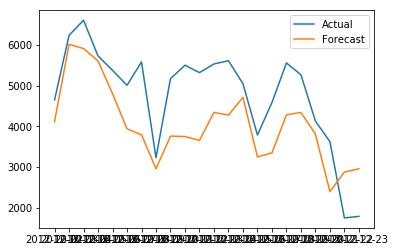

In [30]:
plt.plot(new_test_df['dteday'].values, new_test_df['cnt'].values, label = "Actual") 
plt.plot(new_test_df['dteday'].values, model.predict(new_test_df[feature_columns_to_use]), label = "Forecast") 
plt.legend() 
plt.show() 

In [31]:
#Calculating the error
np.mean(np.sqrt(np.square((new_test_df['cnt'].values-model.predict(new_test_df[feature_columns_to_use]))/new_test_df['cnt'].values)))

0.22543725332921846

In [32]:
print(model.coef_)  

[  5.37286252e+02   4.71691227e+03  -2.21541365e+03  -3.01586064e+03
  -4.33140305e+02  -6.73490575e+02  -5.71588328e+02  -5.18084567e+02
  -5.49905282e+02  -5.60893666e+02  -6.22790350e+02   9.34418810e+02
  -3.66510041e+02   1.87431157e+03   1.43923672e+03   3.93781671e-02
  -3.29522873e-02   1.65155417e-01   1.43924850e-01  -4.07937090e-01
   4.83581193e-01   1.02207296e-01   7.92944110e-02   1.38770905e-01
  -4.21104374e-01   7.00762145e-01   4.18817137e-01  -3.49129372e-01
   4.03744596e-01  -6.40596757e-01   1.92367819e+00   1.63400097e+00
  -4.08117639e-01   2.82483297e-02  -6.70048874e-03  -3.42973021e-01
   1.61634323e-01  -6.65402050e-01   1.00653864e-01  -8.72243180e-01
   9.56934482e-01   7.70526618e-01  -4.52036221e-01  -6.49661239e-02
   8.98678534e-01  -2.03895885e+00   1.24983528e+00   4.14370166e-03
  -3.84950771e+01  -7.79814320e+02  -6.86923296e+01   4.01958678e+02
   4.23594349e+02  -2.57827365e+02   9.52410431e+02   1.84393254e+02
   3.37676044e+02   6.01125331e+02

In [33]:
import statsmodels.api as sm

/Users/sourabhmittal/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [34]:
model = sm.OLS(new_train_df['cnt'],new_train_df[feature_columns_to_use]).fit()

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     402.6
Date:                Mon, 25 Feb 2019   Prob (F-statistic):               0.00
Time:                        11:32:21   Log-Likelihood:                -4175.7
No. Observations:                 520   AIC:                             8469.
Df Residuals:                     461   BIC:                             8720.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
workingday      530.8023    220.446      2.408      0.016      97.599     964.006
atemp          4736.9119    611.642      7.745      0.000    3534.959    5938.865
hum           -2161.5171    403.853     -5.352      0.000   -2955.138   -1367.896
windspeed     -2966.0798    516.274     -5.745      0.000   -3980.621   -1951.538
weekday_0      -436.1034    136.978     -3.184      0.002    -705.282    -166.925
weekday_1      -670.7328    229.932     -2.917      0.004   -1122.577    -218.889
weekday_2      -564.2983    258.793     -2.180      0.030   -1072.859     -55.737
weekday_3      -510.5342    256.165     -1.993      0.047   -1013.929      -7.139
weekday_4      -542.5590    252.181     -2.151      0.032   -1038.126     -46.992
weekday_5      -552.5025    253.203     -2.182      0.030   -1050.078     -54.927
season_1       -663.1770    319.234     -2.077      0.038   -1290.510     -35.844
season_2        932.5324    403.974      2.308      0.021     138.673    1726.391
season_3       -372.0947    242.913     -1.532      0.126    -849.449     105.260
weather_1      1907.9007    245.620      7.768      0.000    1425.228    2390.573
weather_2      1466.5637    229.883      6.380      0.000    1014.815    1918.313
cnt_mean1         0.0405      0.050      0.807      0.420      -0.058       0.139
cnt_mean3        -0.0328      0.025     -1.318      0.188      -0.082       0.016
cnt_median3       0.1693      0.109      1.550      0.122      -0.045       0.384
cnt_min3          0.1456      0.640      0.227      0.820      -1.113       1.404
cnt_max3         -0.4132      0.589     -0.701      0.483      -1.571       0.744
cnt_std3          0.4883      1.186      0.412      0.681      -1.843       2.820
cnt_mean7         0.1018      0.495      0.206      0.837      -0.870       1.074
cnt_median7       0.0854      0.271      0.315      0.753      -0.448       0.619
cnt_min7          0.1465      0.232      0.631      0.529      -0.310       0.603
cnt_max7         -0.4326      0.317     -1.366      0.173      -1.055       0.190
cnt_std7          0.7197      0.743      0.969      0.333      -0.740       2.179
cnt_mean14        0.4049      0.619      0.654      0.513      -0.811       1.621
cnt_median14     -0.3398      0.449     -0.757      0.449      -1.222       0.542
cnt_min14         0.3917      0.163      2.396      0.017       0.070       0.713
cnt_max14        -0.6359      0.264     -2.411      0.016      -1.154      -0.118
cnt_std14         1.8758      0.764      2.454      0.014       0.374       3.378
cnt_mean30        1.5686      0.969      1.619      0.106      -0.335       3.472
cnt_median30     -0.3798      0.697     -0.545      0.586      -1.750       0.991
cnt_min30         0.0179      0.163      0.110      0.913      -0.303       0.339
cnt_max30         0.0101      0.273      0.037   

In [36]:
import lightgbm as lgb

ImportError: No module named lightgbm

In [ ]:
cate_vars = []
params = {
        'num_leaves': 10,
        'objective': 'regression',
        'min_data_in_leaf': 10,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.7,
        'bagging_freq': 1,
        'metric': 'l2',
        'num_threads': 16
}

MAX_ROUNDS = 1500


dtrain = lgb.Dataset(
    new_train_df[feature_columns_to_use], label=new_train_df['cnt'],
    categorical_feature=cate_vars
)
dval = lgb.Dataset(
    new_test_df[feature_columns_to_use], label=new_test_df['cnt'], reference=dtrain,
    categorical_feature=cate_vars)
bst = lgb.train(
    params, dtrain, num_boost_round=MAX_ROUNDS,
    valid_sets=[dtrain, dval],  verbose_eval=50
)
print("\n".join(("%s: %.2f" % x) for x in sorted(
    zip(new_train_df[feature_columns_to_use], bst.feature_importance("gain")),
    key=lambda x: x[1], reverse=True
)))
lgb_pred = bst.predict(
    new_test_df[feature_columns_to_use], num_iteration=bst.best_iteration or MAX_ROUNDS)



In [ ]:
np.mean(np.sqrt(np.square((new_test_df['cnt'].values-lgb_pred)/new_test_df['cnt'].values)))

In [ ]:
print (lgb_pred)

In [ ]:
plt.plot(new_test_df['dteday'].values, new_test_df['cnt'].values, label = "Actual") 
plt.plot(new_test_df['dteday'].values, lgb_pred, label = "Forecast") 
plt.legend() 
plt.show() 